In [2]:
import pickle
import theano
import scipy as sp

theano.config.floatX = 'float32'
%run -i common.ipynb

# FIGURE AND GRID
FIG_HEIGHT_MM = 50
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 1
ROW_1_NCOLS = 3
ROW_1_HEIGHT_MM = FIG_HEIGHT_MM
ROW_1_WIDTH_COL_1_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_2_MM = FIG_WIDTH_MM / ROW_1_NCOLS
ROW_1_WIDTH_COL_3_MM = FIG_WIDTH_MM / ROW_1_NCOLS

PATH_DROPBOX_FIGS = './'

# PATHS
PANEL_A = PATH_DROPBOX_FIGS + 'fig1_a.svg'
PANEL_B = PATH_DROPBOX_FIGS + 'fig1_b.svg'
PANEL_C = PATH_DROPBOX_FIGS + 'fig1_c.svg'

In [71]:
# loading filename and paths
prefix = 'nokernelt05'
basepath = '../results/sqrt/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'

num_results_path = 'posterior'
lw_results_path = 'lwlist'

# create folder for plots
save_plot_flag = 1
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)
# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs
# posterior
l_posteriors = list(posteriors.items())

N = -1
net = io.nth(nets, N)

In [72]:
# no need toexecute unless you want regenerate panel_b
xdatafile = open(num_results_path, 'rb')
xdata = pickle.load(xdatafile)

x0_grid = xdata['pts'][:,0]

true_means = xdata['data'][:,0]
true_covs = xdata['data'][:,1]

# Will consider the following point
idx = int(len(x0_grid) * (0.43) )
obs_stats = x0_grid[idx]
true_mean = true_means[idx]
true_cov = true_covs[idx]

# Model parameters
#prior_cov=3.0
#prior_mean=5.
noise_cov=0.1
eps = 0.3

prior_cov = io.nth(infos,N)['prior_true'].S[0,0]
prior_mean = io.nth(infos,N)['prior_true'].m[0]

prop_prior_cov = io.nth(infos,N)['prior_proposal'].xs[0].S[0,0]
prop_prior_mean = io.nth(infos,N)['prior_proposal'].xs[0].m[0]

# Consider y values in the following range
n_grid = 100
lims = np.array([[0],[10]])
yy = np.linspace(lims[0,0],lims[1,0],n_grid)

_, post_mean, post_prec = net.eval_comps(np.reshape(obs_stats,(-1,1)))
post_mean = post_mean[0][0][0]
post_cov = 1. / post_prec[0][0][0] ** 2
_, post_means, post_precs = net.eval_comps(np.reshape(x0_grid,(-1,1)))
post_means = np.array(post_means).flatten()
post_covs = 1. / np.array(post_precs).flatten() ** 2

lwfile = open(lw_results_path, 'rb')
lwdata = pickle.load(lwfile)

param_list = lwdata['pts']
lwlist = lwdata['data']

optidx = np.argmin(lwlist)
optparam = param_list[optidx]

param_means = optparam[0] + optparam[1] * x0_grid + optparam[3] * (x0_grid ** 2)
param_mean = param_means[idx]
param_vars = param_var = optparam[2] ** 2

In [73]:
def gauss1D(x,mean,var):
    return ((2 * np.pi) ** (-0.5)) * (1 / np.sqrt(var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)

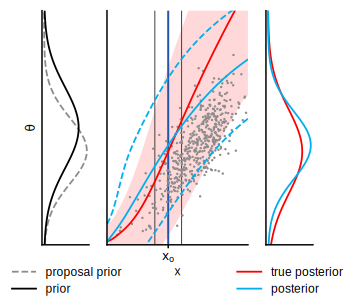

In [66]:
###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
theta_samp = np.sqrt(prop_prior_cov)*np.random.randn(n_samp) + prop_prior_mean
x_samp = np.sqrt(noise_cov)*np.random.randn(n_samp)+np.sqrt(np.abs(theta_samp))

###############################################################################
# contour values for prior, true posterior and estimated posterior
pp_prior = gauss1D(yy,prior_mean,prior_cov)
prop_prior = gauss1D(yy,prop_prior_mean,prop_prior_cov)
pp_post = gauss1D(yy,post_mean,post_cov)
pp_true_xo = gauss1D(yy,true_mean,true_cov)
pp_param = gauss1D(yy,param_mean,param_var)

fake_means = sp.ndimage.filters.gaussian_filter(true_means, sigma=3)
fake_covs = sp.ndimage.filters.gaussian_filter(true_covs, sigma=3)

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(0.93*ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))
FIG_WIDTH_MM *= 2
with mpl.rc_context(fname=MPL_RC):
    plt.figure(figsize=fig_inches)
    ax = plt.subplot()

    # True posterior
    col_0 = (255/255,0/255,0/255)
    #col_0 = COL['GT']
    col_1 = (0, 174/255,239/255)
    # Posterior
    # col_2 = (244/255, 152/255, 25/255)
    col_2 = COL['SNPE']
    # Parametrised posterior
    col_3 = (0,200/255,0)
    # x0
    col_4 = (35/255,86/255,167/255)

    gs = mpl.gridspec.GridSpec(1, 3, width_ratios=[1, 3, 1])

    # LEFTHAND SIDE
    axl = plt.subplot(gs[0])
    plt.plot(prop_prior,yy,'--',color='0.55', label='proposal prior')
    plt.plot(pp_prior,yy,color='0.0', label='prior')
    axl.set_ylim(lims)
    axl.set_yticks([])
    axl.set_xticks([])
    plt.ylabel(r'$\theta$')
    axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    
    axr = plt.subplot(gs[2])
      
    # RIGHTHAND SIDE
    plt.plot(pp_true_xo,yy,color=col_0, label='true posterior')
    plt.plot(pp_post,yy,color=col_2, label='posterior')
    #plt.plot(pp_param,yy,color=col_3, label='parametrised posterior')
    axr.set_ylim(lims)
    #ax.set_xticks([])
    axr.set_xticks([])
    plt.ylabel('')
    axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    #plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    

    hl, ll = axl.get_legend_handles_labels()
    hr, lr = axr.get_legend_handles_labels()
    axr.set_yticks([])
    
    axm = plt.subplot(gs[1])
    plt.ylabel('')
    
    # Draw true posterior
    plt.plot(x_samp, theta_samp,'.',color='0.55')
    #plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
    plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')
    
    #plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
    #plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
    plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
                     fake_means+2 * np.sqrt(fake_covs),
                     facecolor=col_0,
                     alpha=0.15)

    # Draw parametrised means (in green)
    #plt.plot(x0_grid,param_means,color=col_3)
    #plt.plot(x0_grid,param_means + 2 * np.sqrt(param_vars),'--',color=col_3)
    #plt.plot(x0_grid,param_means - 2 * np.sqrt(param_vars),'--',color=col_3)
    
    # Draw posterior means (in orange)
    plt.plot(x0_grid,post_means,color=col_2, label='posterior')
    plt.plot(x0_grid,post_means + 2 * np.sqrt(post_covs),'--',color=col_2)
    plt.plot(x0_grid,post_means - 2 * np.sqrt(post_covs),'--',color=col_2)
    
    #plt.fill_between(x0_grid,post_means-2 * np.sqrt(post_covs),
    #                 post_means+2 * np.sqrt(post_covs),
    #                 facecolor=col_2,
    #                 alpha=0.15)
    
    # Draw vertical lines around chosen point
    axm.vlines(obs_stats, 0, axm.get_ylim()[1], lw=2, color=col_4)
    axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
    axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

    axm.set_xlim(np.sqrt(lims))
    axm.set_ylim(lims)
    #ax.set_xticks([])
    axm.set_yticks([])
    plt.xlabel('x')
    #plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

    plt.xticks([obs_stats], [r'$x_{o}$'])

    plt.tight_layout()

    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()
svg(PANEL_B)

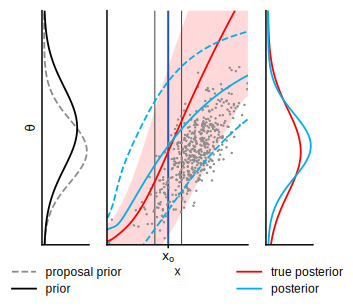

In [70]:
###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
theta_samp = np.sqrt(prop_prior_cov)*np.random.randn(n_samp) + prop_prior_mean
x_samp = np.sqrt(noise_cov)*np.random.randn(n_samp)+np.sqrt(np.abs(theta_samp))

###############################################################################
# contour values for prior, true posterior and estimated posterior
pp_prior = gauss1D(yy,prior_mean,prior_cov)
prop_prior = gauss1D(yy,prop_prior_mean,prop_prior_cov)
pp_post = gauss1D(yy,post_mean,post_cov)
pp_true_xo = gauss1D(yy,true_mean,true_cov)
pp_param = gauss1D(yy,param_mean,param_var)

fake_means = sp.ndimage.filters.gaussian_filter(true_means, sigma=3)
fake_covs = sp.ndimage.filters.gaussian_filter(true_covs, sigma=3)

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(0.93*ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))
FIG_WIDTH_MM *= 2
with mpl.rc_context(fname=MPL_RC):
    plt.figure(figsize=fig_inches)
    ax = plt.subplot()

    # True posterior
    col_0 = (255/255,0/255,0/255)
    #col_0 = COL['GT']
    col_1 = (0, 174/255,239/255)
    # Posterior
    # col_2 = (244/255, 152/255, 25/255)
    col_2 = COL['SNPE']
    # Parametrised posterior
    col_3 = (0,200/255,0)
    # x0
    col_4 = (35/255,86/255,167/255)

    gs = mpl.gridspec.GridSpec(1, 3, width_ratios=[1, 3, 1])

    # LEFTHAND SIDE
    axl = plt.subplot(gs[0])
    plt.plot(prop_prior,yy,'--',color='0.55', label='proposal prior')
    plt.plot(pp_prior,yy,color='0.0', label='prior')
    axl.set_ylim(lims)
    axl.set_yticks([])
    axl.set_xticks([])
    plt.ylabel(r'$\theta$')
    axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    
    axr = plt.subplot(gs[2])
      
    # RIGHTHAND SIDE
    plt.plot(pp_true_xo,yy,color=col_0, label='true posterior')
    plt.plot(pp_post,yy,color=col_2, label='posterior')
    #plt.plot(pp_param,yy,color=col_3, label='parametrised posterior')
    axr.set_ylim(lims)
    #ax.set_xticks([])
    axr.set_xticks([])
    plt.ylabel('')
    axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    #plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    

    hl, ll = axl.get_legend_handles_labels()
    hr, lr = axr.get_legend_handles_labels()
    axr.set_yticks([])
    
    axm = plt.subplot(gs[1])
    plt.ylabel('')
    
    # Draw true posterior
    plt.plot(x_samp, theta_samp,'.',color='0.55')
    #plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
    plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')
    
    #plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
    #plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
    plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
                     fake_means+2 * np.sqrt(fake_covs),
                     facecolor=col_0,
                     alpha=0.15)

    # Draw parametrised means (in green)
    #plt.plot(x0_grid,param_means,color=col_3)
    #plt.plot(x0_grid,param_means + 2 * np.sqrt(param_vars),'--',color=col_3)
    #plt.plot(x0_grid,param_means - 2 * np.sqrt(param_vars),'--',color=col_3)
    
    # Draw posterior means (in orange)
    plt.plot(x0_grid,post_means,color=col_2, label='posterior')
    plt.plot(x0_grid,post_means + 2 * np.sqrt(post_covs),'--',color=col_2)
    plt.plot(x0_grid,post_means - 2 * np.sqrt(post_covs),'--',color=col_2)
    
    #plt.fill_between(x0_grid,post_means-2 * np.sqrt(post_covs),
    #                 post_means+2 * np.sqrt(post_covs),
    #                 facecolor=col_2,
    #                 alpha=0.15)
    
    # Draw vertical lines around chosen point
    axm.vlines(obs_stats, 0, axm.get_ylim()[1], lw=2, color=col_4)
    axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
    axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

    axm.set_xlim(np.sqrt(lims))
    axm.set_ylim(lims)
    #ax.set_xticks([])
    axm.set_yticks([])
    plt.xlabel('x')
    #plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

    plt.xticks([obs_stats], [r'$x_{o}$'])

    plt.tight_layout()

    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()
svg(PANEL_B)

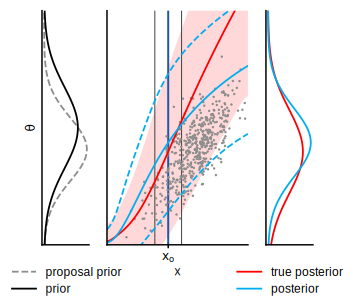

In [74]:
###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
theta_samp = np.sqrt(prop_prior_cov)*np.random.randn(n_samp) + prop_prior_mean
x_samp = np.sqrt(noise_cov)*np.random.randn(n_samp)+np.sqrt(np.abs(theta_samp))

###############################################################################
# contour values for prior, true posterior and estimated posterior
pp_prior = gauss1D(yy,prior_mean,prior_cov)
prop_prior = gauss1D(yy,prop_prior_mean,prop_prior_cov)
pp_post = gauss1D(yy,post_mean,post_cov)
pp_true_xo = gauss1D(yy,true_mean,true_cov)
pp_param = gauss1D(yy,param_mean,param_var)

fake_means = sp.ndimage.filters.gaussian_filter(true_means, sigma=3)
fake_covs = sp.ndimage.filters.gaussian_filter(true_covs, sigma=3)

# matplotlib takes figsize specified as inches
# in NIPS2016 SCALE_IN and the conversion function are defined
fig_inches = (SCALE_IN*mm2inches(0.93*ROW_1_WIDTH_COL_2_MM), SCALE_IN*mm2inches(0.93*ROW_1_HEIGHT_MM))
FIG_WIDTH_MM *= 2
with mpl.rc_context(fname=MPL_RC):
    plt.figure(figsize=fig_inches)
    ax = plt.subplot()

    # True posterior
    col_0 = (255/255,0/255,0/255)
    #col_0 = COL['GT']
    col_1 = (0, 174/255,239/255)
    # Posterior
    # col_2 = (244/255, 152/255, 25/255)
    col_2 = COL['SNPE']
    # Parametrised posterior
    col_3 = (0,200/255,0)
    # x0
    col_4 = (35/255,86/255,167/255)

    gs = mpl.gridspec.GridSpec(1, 3, width_ratios=[1, 3, 1])

    # LEFTHAND SIDE
    axl = plt.subplot(gs[0])
    plt.plot(prop_prior,yy,'--',color='0.55', label='proposal prior')
    plt.plot(pp_prior,yy,color='0.0', label='prior')
    axl.set_ylim(lims)
    axl.set_yticks([])
    axl.set_xticks([])
    plt.ylabel(r'$\theta$')
    axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    
    axr = plt.subplot(gs[2])
      
    # RIGHTHAND SIDE
    plt.plot(pp_true_xo,yy,color=col_0, label='true posterior')
    plt.plot(pp_post,yy,color=col_2, label='posterior')
    #plt.plot(pp_param,yy,color=col_3, label='parametrised posterior')
    axr.set_ylim(lims)
    #ax.set_xticks([])
    axr.set_xticks([])
    plt.ylabel('')
    axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=1)
    #plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    

    hl, ll = axl.get_legend_handles_labels()
    hr, lr = axr.get_legend_handles_labels()
    axr.set_yticks([])
    
    axm = plt.subplot(gs[1])
    plt.ylabel('')
    
    # Draw true posterior
    plt.plot(x_samp, theta_samp,'.',color='0.55')
    #plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
    plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')
    
    #plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
    #plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
    plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
                     fake_means+2 * np.sqrt(fake_covs),
                     facecolor=col_0,
                     alpha=0.15)

    # Draw parametrised means (in green)
    #plt.plot(x0_grid,param_means,color=col_3)
    #plt.plot(x0_grid,param_means + 2 * np.sqrt(param_vars),'--',color=col_3)
    #plt.plot(x0_grid,param_means - 2 * np.sqrt(param_vars),'--',color=col_3)
    
    # Draw posterior means (in orange)
    plt.plot(x0_grid,post_means,color=col_2, label='posterior')
    plt.plot(x0_grid,post_means + 2 * np.sqrt(post_covs),'--',color=col_2)
    plt.plot(x0_grid,post_means - 2 * np.sqrt(post_covs),'--',color=col_2)
    
    #plt.fill_between(x0_grid,post_means-2 * np.sqrt(post_covs),
    #                 post_means+2 * np.sqrt(post_covs),
    #                 facecolor=col_2,
    #                 alpha=0.15)
    
    # Draw vertical lines around chosen point
    axm.vlines(obs_stats, 0, axm.get_ylim()[1], lw=2, color=col_4)
    axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
    axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

    axm.set_xlim(np.sqrt(lims))
    axm.set_ylim(lims)
    #ax.set_xticks([])
    axm.set_yticks([])
    plt.xlabel('x')
    #plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

    plt.xticks([obs_stats], [r'$x_{o}$'])

    plt.tight_layout()

    plt.savefig(PANEL_B, facecolor=plt.gcf().get_facecolor(), transparent=True)  # the figure is saved as svg
    plt.close()
svg(PANEL_B)